<a href="https://colab.research.google.com/github/asravankumar/END2.0/blob/master/session_5/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data Loaders to Download, Preprocess & Create Training/Validation DataSet**

The data is a set of Rotten Tomatoes Movie Reviews labelled and provided readily by stanford.
The raw data is available in two formats
- raw csv files.
- Penn Treebank(PTB tree) format.

The raw csv files contains list of files which consists of list of 
- sentences
- phrases
- trees mapping sentences and phrases
- sentiment of each phrase.

The PTB format consists of the sentences, and the respective phrases in tree format.

In order to get the sentiment of each sentences, we need to parse the tree structure. [pytreebank](https://github.com/JonathanRaiman/pytreebank)  does the job effectively.

We download the sentences and sentiments from [pytreebank](https://github.com/JonathanRaiman/pytreebank) and build models.

**Data Download to CSV File**

In [ ]:
!pip install pytreebank

  Created wheel for pytreebank: filename=pytreebank-0.2.7-cp37-none-any.whl size=37070 sha256=6120444dc2b77cffd686549d60fe43368592d0b31aff78dae0d3a8a62131098a
  Stored in directory: /root/.cache/pip/wheels/e0/b6/91/e9edcdbf464f623628d5c3aa9de28888c726e270b9a29f2368
Successfully built pytreebank


Stanford Sentiment Treebank Data splits into train, dev and test sets. We therefore maintain the split as given by them.

In [ ]:
import pytreebank
dataset = pytreebank.load_sst()

for category in ['train', 'test', 'dev']:
  out_file = open('sentences_{}.txt'.format(category), 'w')
  out_file.write('{}\t{}\n'.format("sentence", "labels"))
  for item in dataset[category]:
    label, sentence = item.to_labeled_lines()[0]
    out_file.write("{}\t{}\n".format(sentence, label))
  out_file.close()

In [ ]:
import pandas as pd
# create training and validation pandas dataframes from downloaded data.

train_df = pd.read_csv('sentences_train.txt', delimiter='\t')
valid_df = pd.read_csv('sentences_dev.txt', delimiter='\t')

In [ ]:
print("training df shape", train_df.shape)
print("validation df shape", valid_df.shape)


training df shape (8544, 2)
validation df shape (1101, 2)


**Understanding our Dataset**

We plot a bar graph on our training data.

Text(0, 0.5, 'number of samples in training dataset')

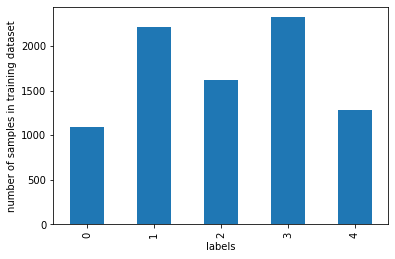

In [ ]:
import matplotlib.pyplot as plt

ax = train_df['labels'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("labels")
ax.set_ylabel("number of samples in training dataset")

We clearly can see there is an **imbalance** in the data w.r.t number of samples for each label. 

labels 1,2,3 have more samples than 0 and 4. 

We need to augment some data in labels 0 and 4 to balance them.


**Data Augmentation**



**- Back Translate**

In [ ]:
!pip install googletrans
!pip install google_trans_new

     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 1.0MB 20.2MB/s 
     |████████████████████████████████| 51kB 8.7MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
     |████████████████████████████████| 71kB 10.9MB/s 
  Created wheel for googletrans: filename=googletrans-3.0.0-cp37-none-any.whl size=15737 sha256=4561a40fed6021b89ca9eac4dfd97bf96f5a7bf9ad0294d00cd234e39131b2af
  Stored in directory: /root/.cache/pip/wheels/28/1a/a7/eaf4d7a3417a0c65796c547cff4deb6d79c7d14c2abd29273e
Successfully built googletrans


In [ ]:
import random
import googletrans, google_trans_new

translator = google_trans_new.google_translator()

def back_translate(sentence):
  available_languages = list(googletrans.LANGUAGES.keys()) 
  selected_language = random.choice(available_languages) 
  translations = translator.translate(sentence, lang_tgt=selected_language) 
  back_translated_text = translator.translate(translations, lang_src=selected_language, lang_tgt='en') 
  return back_translated_text

In [ ]:
back_translate("training the model")

'Model training '

**- Random Swap**

In [ ]:
def random_swap(sentence, n=5): 
    length = range(len(sentence)) 
    for _ in range(n):
        idx1, idx2 = random.sample(length, 2)
        sentence[idx1], sentence[idx2] = sentence[idx2], sentence[idx1] 
    return sentence

In [ ]:
random_swap("training the model".split(' '), 1)

['training', 'model', 'the']

**- Random Deletion**

In [ ]:
def random_deletion(words, p=0.5): 
    if len(words) == 1: # return if single word
        return words
    remaining = list(filter(lambda x: random.uniform(0,1) > p,words)) 
    if len(remaining) == 0: # if not left, sample a random word
        return [random.choice(words)] 
    else:
        return remaining

In [ ]:
random_deletion("training the model".split(' '), 0.2)

['training', 'the']

We shall augment the datasets based on the above three techniques

As we can see from the data, the labels 0 and 4 are less than that of others, we shall back translate few random samples and populate these.

In [ ]:
train_df

,sentence,labels
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3
...,...,...
8539,A real snooze .,0
8540,No surprises .,1
8541,We 've seen the hippie-turned-yuppie plot befo...,3
8542,Her fans walked out muttering words like `` ho...,0


In [ ]:
train_df.loc[7163]

sentence    Collapses after 30 minutes into a slap-happy s...
labels                                                      0
Name: 7163, dtype: object

In [ ]:
def back_translate_sentences_based_on_label(label, new_sentences_count):
  label_indexes = train_df[train_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, new_sentences_count)
  new_label_sentences = []
  for index in selected_indexes:
    sentence = train_df.loc[index].sentence
    back_translated_sentence = back_translate(sentence)
    new_label_sentences.append([back_translated_sentence, label])
  new_df = pd.DataFrame(new_label_sentences, columns=['sentence', 'labels'])
  return(new_df)

new_label_0_df = back_translate_sentences_based_on_label(0, 400)
new_label_1_df = back_translate_sentences_based_on_label(4, 200)

In [ ]:
new_augmented_train_df = pd.concat([train_df, new_label_0_df, new_label_1_df], ignore_index=True)

In [ ]:
new_augmented_train_df.labels.value_counts()

3    2322
1    2218
2    1624
0    1492
4    1488
Name: labels, dtype: int64

Let's augment using random_swap on rest of the labels 1,2,3

In [ ]:
def random_swap_sentences_on_labels(temp_df, label, count):
  label_indexes = temp_df[temp_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, count)
  #print("selected_indexes", selected_indexes)
  for index in selected_indexes:
    sentence = temp_df.loc[index].sentence
    #print("index", index, "sentence", sentence)
    new_sentence = random_swap(sentence.split(' '), 2)
    temp_df.loc[index].sentence = new_sentence
  return(temp_df)

temp_df = new_augmented_train_df.copy()
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 2, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 3, 150)

In [ ]:
def random_delete_sentences_on_labels(temp_df, label, count):
  label_indexes = temp_df[temp_df['labels'] == label].index.tolist()
  selected_indexes = random.sample(label_indexes, count)
  #print("selected_indexes", selected_indexes)
  for index in selected_indexes:
    sentence = temp_df.loc[index].sentence
    #print("index", index, "sentence", sentence)
    new_sentence = random_deletion(sentence.split(' '), 2)
    temp_df.loc[index].sentence = new_sentence
  return(temp_df)

temp_df = temp_df.copy()
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 1, 100)
temp_df = random_swap_sentences_on_labels(temp_df, 1, 150)

In [ ]:
new_train_df = temp_df

In [ ]:
new_train_df

,sentence,labels
0,The Rock is destined to be the 21st Century 's...,3
1,The gorgeously elaborate continuation of `` Th...,4
2,Singer/composer Bryan Adams contributes a slew...,3
3,You 'd think by now America would have had eno...,2
4,Yet the act is still charming here .,3
...,...,...
9139,CHO's time is invaluable.,4
9140,Piccoli gives excellent performance full of de...,4
9141,The lack of note of * Corpus and its pleasant ...,4
9142,"... a wonderful, funny, funny funny funny.",4


In [ ]:
new_train_df.labels.value_counts()

3    2322
1    2218
2    1624
0    1492
4    1488
Name: labels, dtype: int64

Text(0, 0.5, 'number of samples in training dataset')

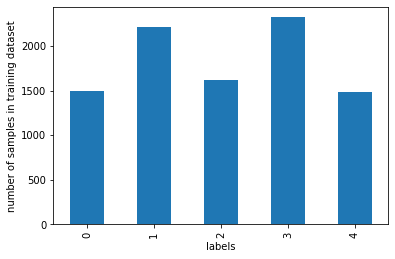

In [ ]:
import matplotlib.pyplot as plt

ax = new_train_df['labels'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("labels")
ax.set_ylabel("number of samples in training dataset")

**Creating TorchDataSets**

The steps includes preprocessing all the sentences and creating torchtext Dataset objects for the model to use. 

The following preprocessing have been performed:
- lower case all sentences
- remove stopwords


In [ ]:
import torch, torchtext
from torchtext import data

SEED = 12
torch.manual_seed(SEED)

In [ ]:
# The list of stop words which are to be removed from training and validation set.
# The list is from nltk package.
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
Sentence  = torchtext.legacy.data.Field(
                  sequential = True,
                  tokenize = 'spacy',
                  batch_first =True,
                  include_lengths=True,
                  lower=True,
                  stop_words=stop_words)

Label     = torchtext.legacy.data.LabelField(
                  tokenize = 'spacy',
                  is_target = True,
                  batch_first = True,
                  sequential = False)
fields = [('sentence', Sentence),('labels',Label)]
train_example = [ torchtext.legacy.data.Example.fromlist([new_train_df.sentence[i], new_train_df.labels[i]], fields) for i in range(1, new_train_df.shape[0])]
valid_example = [ torchtext.legacy.data.Example.fromlist([valid_df.sentence[i], valid_df.labels[i]], fields) for i in range(1, valid_df.shape[0])]
train_dataset = torchtext.legacy.data.Dataset(train_example, fields)
valid_dataset = torchtext.legacy.data.Dataset(valid_example, fields)

We limit the vocab to 8000 tokens.

In [130]:
Sentence.build_vocab(train_dataset, max_size=8000)
Label.build_vocab(train_dataset, max_size=8000)

In [131]:
print('Size of input vocab : ', len(Sentence.vocab))
print('Size of label vocab : ', len(Label.vocab))
print('Top 10 words appeared repeatedly :', list(Sentence.vocab.freqs.most_common(10)))
print('Labels : ', Label.vocab.stoi)

Size of input vocab :  8002
Size of label vocab :  5
Top 10 words appeared repeatedly : [('.', 8595), (',', 7631), ('-', 2876), ("'s", 2611), ('film', 1249), ('movie', 1103), ('`', 811), ('...', 696), ("n't", 695), ('one', 609)]
Labels :  defaultdict(None, {3: 0, 1: 1, 2: 2, 0: 3, 4: 4})


**Check the device used**

In [132]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [142]:
train_iterator, valid_iterator = torchtext.legacy.data.BucketIterator.splits((train_dataset, valid_dataset), batch_size = 32, 
                                                            sort_key = lambda x: len(x.sentence),
                                                            sort_within_batch=True, device = device)

**Training**

In [143]:
import torch.nn as nn
import torch.nn.functional as F

class classifier(nn.Module):
    
    # Define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        
        super().__init__()          
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # LSTM layer
        self.encoder = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           dropout=dropout,
                           batch_first=True)
        # try using nn.GRU or nn.RNN here and compare their performances
        # try bidirectional and compare their performances
        
        # Dense layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, text, text_lengths):
        
        # text = [batch size, sent_length]
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]
      
        # packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True)
        
        packed_output, (hidden, cell) = self.encoder(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
    
        # Hidden = [batch size, hid dim * num directions]
        dense_outputs = self.fc(hidden)   
        
        # Final activation function softmax
        output = F.softmax(dense_outputs[0], dim=1)
            
        return output

In [144]:
# Define hyperparameters
size_of_vocab = len(Sentence.vocab)
embedding_dim = 300
num_hidden_nodes = 100
num_output_nodes = 5
num_layers = 2
dropout = 0.2

# Instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout = dropout)

In [145]:
print(model)

#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

classifier(
  (embedding): Embedding(8002, 300)
  (encoder): LSTM(300, 100, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=100, out_features=5, bias=True)
)
The model has 2,642,705 trainable parameters


In [146]:
import torch.optim as optim

# define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()

# define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    _, predictions = torch.max(preds, 1)
    
    correct = (predictions == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
# push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [147]:
def train(model, iterator, optimizer, criterion):
    
    # initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    # set the model in training phase
    model.train()  
    
    for batch in iterator:
        
        # resets the gradients after every batch
        optimizer.zero_grad()   
        
        # retrieve text and no. of words
        sentence, sentence_lengths = batch.sentence   
        
        # convert to 1D tensor
        predictions = model(sentence, sentence_lengths).squeeze()
        
        # compute the loss
        loss = criterion(predictions, batch.labels)        
        
        # compute the binary accuracy
        acc = binary_accuracy(predictions, batch.labels)   
        
        # backpropage the loss and compute the gradients
        loss.backward()       
        
        # update the weights
        optimizer.step()      
        
        # loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [148]:
def evaluate(model, iterator, criterion):
    
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and no. of words
            sentence, sentence_lengths = batch.sentence
            
            # convert to 1d tensor
            predictions = model(sentence, sentence_lengths).squeeze()
            
            # compute loss and accuracy
            loss = criterion(predictions, batch.labels)
            acc = binary_accuracy(predictions, batch.labels)
            
            # keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [149]:
N_EPOCHS = 20
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    # train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    # evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    # save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% \n')

	Train Loss: 1.593 | Train Acc: 25.56%
	 Val. Loss: 1.579 |  Val. Acc: 27.71% 

	Train Loss: 1.582 | Train Acc: 29.12%
	 Val. Loss: 1.570 |  Val. Acc: 29.35% 

	Train Loss: 1.552 | Train Acc: 34.43%
	 Val. Loss: 1.544 |  Val. Acc: 33.96% 

	Train Loss: 1.500 | Train Acc: 39.29%
	 Val. Loss: 1.541 |  Val. Acc: 34.35% 

	Train Loss: 1.450 | Train Acc: 45.25%
	 Val. Loss: 1.535 |  Val. Acc: 35.36% 

	Train Loss: 1.399 | Train Acc: 51.61%
	 Val. Loss: 1.527 |  Val. Acc: 35.42% 

	Train Loss: 1.346 | Train Acc: 58.07%
	 Val. Loss: 1.537 |  Val. Acc: 34.40% 

	Train Loss: 1.295 | Train Acc: 64.05%
	 Val. Loss: 1.535 |  Val. Acc: 34.88% 

	Train Loss: 1.246 | Train Acc: 69.25%
	 Val. Loss: 1.544 |  Val. Acc: 33.12% 

	Train Loss: 1.203 | Train Acc: 73.62%
	 Val. Loss: 1.549 |  Val. Acc: 32.68% 

	Train Loss: 1.166 | Train Acc: 77.15%
	 Val. Loss: 1.546 |  Val. Acc: 33.57% 

	Train Loss: 1.136 | Train Acc: 80.05%
	 Val. Loss: 1.547 |  Val. Acc: 33.63% 

	Train Loss: 1.111 | Train Acc: 81.84%
	